# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

## PreProcessing

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
df = pd.read_csv(r"C:\Users\gagan\Downloads\Data\Winter 23-24\Capstone\fraud-transactions-detection\JPMorgan\SupervisedFraudData.csv")
df.head()

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,Date,Time
0,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537,CCB,Unknown,Unknown,Unknown,558.43,0,WITHDRAWAL,2022-01-15,37440
1,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,2022-01-15,37440
2,DEPOSIT-CASH-9833,Unknown,Unknown,Unknown,0,Unknown,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,2022-01-15,37440
3,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,2022-01-15,37440
4,DEPOSIT-CHECK-9806,Unknown,Unknown,Unknown,0,Unknown,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,2022-01-15,37440


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498177 entries, 0 to 1498176
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Transaction_Id    1498177 non-null  object 
 1   Sender_Id         1498177 non-null  object 
 2   Sender_Account    1498177 non-null  object 
 3   Sender_Country    1498177 non-null  object 
 4   Sender_Sector     1498177 non-null  int64  
 5   Sender_lob        1498177 non-null  object 
 6   Bene_Id           1498177 non-null  object 
 7   Bene_Account      1498177 non-null  object 
 8   Bene_Country      1498177 non-null  object 
 9   USD_amount        1498177 non-null  float64
 10  Label             1498177 non-null  int64  
 11  Transaction_Type  1498177 non-null  object 
 12  Date              1498177 non-null  object 
 13  Time              1498177 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 160.0+ MB


In [5]:
df.describe()

,Sender_Sector,USD_amount,Label,Time
count,1.498177e+06,1.498177e+06,1.498177e+06,1.498177e+06
mean,2.136568e+04,5.134698e+02,2.057100e-02,4.315844e+04
std,1.599846e+04,5.398089e+02,1.419431e-01,2.489621e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+02
25%,6.078000e+03,1.386900e+02,0.000000e+00,2.139500e+04
50%,2.075700e+04,4.041600e+02,0.000000e+00,4.347800e+04
75%,3.539000e+04,7.340700e+02,0.000000e+00,6.456200e+04
max,4.999900e+04,1.999894e+04,1.000000e+00,8.624400e+04


In [6]:
from datetime import datetime
def convert_to_unix(date_string):
    date_object = datetime.strptime(date_string, "%Y-%m-%d")
    return int(date_object.timestamp())

# Apply the function to the DataFrame column 'Date'
df['Unix_Timestamp'] = df['Date'].apply(convert_to_unix)

df

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,Date,Time,Unix_Timestamp
0,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537,CCB,Unknown,Unknown,Unknown,558.43,0,WITHDRAWAL,2022-01-15,37440,1642185000
1,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,2022-01-15,37440,1642185000
2,DEPOSIT-CASH-9833,Unknown,Unknown,Unknown,0,Unknown,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,2022-01-15,37440,1642185000
3,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,2022-01-15,37440,1642185000
4,DEPOSIT-CHECK-9806,Unknown,Unknown,Unknown,0,Unknown,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,2022-01-15,37440,1642185000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498172,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701,CCB,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT,2054-01-14,47844,2651941800
1498173,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT,2054-01-15,3444,2652028200
1498174,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784,CCB,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT,2054-01-15,4644,2652028200
1498175,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT,2054-01-15,46644,2652028200


C:\Users\gagan\AppData\Local\Temp\ipykernel_14280\3853720792.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Label'], sort = True)


Text(0, 0.5, 'Frequency')

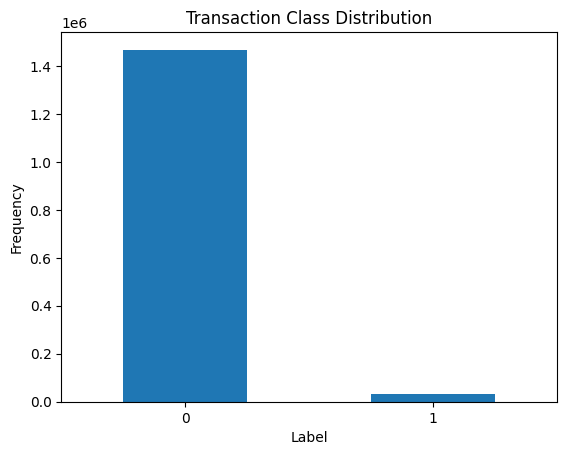

In [7]:
count_classes = pd.value_counts(df['Label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")


plt.xlabel("Label")

plt.ylabel("Frequency")

In [8]:
fraud = df[df['Label'] == 1]
normal = df[df['Label'] == 0]

In [9]:
print(fraud.shape,normal.shape)

(30819, 15) (1467358, 15)


In [10]:
fraud.USD_amount.describe()

count    30819.000000
mean       847.442043
std       2003.566402
min        100.000000
25%        254.115000
50%        512.230000
75%        773.975000
max      19998.940000
Name: USD_amount, dtype: float64

In [11]:
normal.USD_amount.describe()

count    1.467358e+06
mean     5.064553e+02
std      4.591433e+02
min      0.000000e+00
25%      1.355300e+02
50%      4.011900e+02
75%      7.330300e+02
max      1.985449e+04
Name: USD_amount, dtype: float64

In [12]:
len(fraud)/len(normal)

0.02100305446932514

In [13]:
df1= df.sample(frac = 0.2,random_state=1)
df1.shape

(299635, 15)

In [14]:
Fraud = df1[df1['Label']==1]

Valid = df1[df1['Label']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [15]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.021007257982076533
Fraud Cases : 6165
Valid Cases : 293470


In [16]:
df1.Sender_lob.value_counts()

Sender_lob
CCB        256055
Unknown     43580
Name: count, dtype: int64

In [17]:
df.drop(['Sender_lob'], axis = 1, inplace = True)

In [18]:
df1.drop(['Sender_lob'], axis = 1, inplace = True)

In [19]:
df1.head()

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,Date,Time,Unix_Timestamp
1281721,WITHDRAWAL-1867978,JPMC-CLIENT-1867749,ACCOUNT-1867772,MAURITIUS,14230,Unknown,Unknown,Unknown,697.17,0,EXCHANGE,2050-01-22,60415,2526402600
1425214,PAYMENT-2069169,JPMC-CLIENT-2068907,ACCOUNT-2068998,ANGUILLA,42259,CLIENT-2068908,ACCOUNT-2068910,CANADA,400.47,0,MAKE-PAYMENT,2053-01-08,65234,2619887400
512558,QUICK-PAYMENT-742999,CLIENT-742801,ACCOUNT-742802,USA,260,JPMC-CLIENT-742782,ACCOUNT-742793,USA,578.51,0,QUICK-PAYMENT,2033-01-28,40509,1990463400
1182495,MOVE-FUNDS-1726011,JPMC-CLIENT-1725931,ACCOUNT-1725978,EGYPT,28353,CLIENT-1725933,ACCOUNT-1725939,CANADA,609.84,0,MOVE-FUNDS,2047-01-23,37602,2431794600
1060940,CASH-CHECK-1542357,JPMC-CLIENT-1542168,ACCOUNT-1542276,USA,44443,Unknown,Unknown,Unknown,674.39,0,EXCHANGE,2045-01-05,77785,2367167400


In [20]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the 'Unix_Timestamp' and 'Time' columns
df1[['Unix_Timestamp', 'Time']] = scaler.fit_transform(df1[['Unix_Timestamp', 'Time']])

df1.head()

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,Date,Time,Unix_Timestamp
1281721,WITHDRAWAL-1867978,JPMC-CLIENT-1867749,ACCOUNT-1867772,MAURITIUS,14230,Unknown,Unknown,Unknown,697.17,0,EXCHANGE,2050-01-22,0.699677,0.874552
1425214,PAYMENT-2069169,JPMC-CLIENT-2068907,ACCOUNT-2068998,ANGUILLA,42259,CLIENT-2068908,ACCOUNT-2068910,CANADA,400.47,0,MAKE-PAYMENT,2053-01-08,0.755709,0.966889
512558,QUICK-PAYMENT-742999,CLIENT-742801,ACCOUNT-742802,USA,260,JPMC-CLIENT-742782,ACCOUNT-742793,USA,578.51,0,QUICK-PAYMENT,2033-01-28,0.468222,0.345195
1182495,MOVE-FUNDS-1726011,JPMC-CLIENT-1725931,ACCOUNT-1725978,EGYPT,28353,CLIENT-1725933,ACCOUNT-1725939,CANADA,609.84,0,MOVE-FUNDS,2047-01-23,0.434422,0.781106
1060940,CASH-CHECK-1542357,JPMC-CLIENT-1542168,ACCOUNT-1542276,USA,44443,Unknown,Unknown,Unknown,674.39,0,EXCHANGE,2045-01-05,0.901644,0.717273


## Encoding

In [21]:
one_hot_encoded = pd.get_dummies(df1['Transaction_Type'], dtype = 'int64')

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df1 = pd.concat([df1.drop(columns=['Transaction_Type']), one_hot_encoded], axis=1)



In [22]:
df1

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,...,Time,Unix_Timestamp,DEPOSIT-CASH,DEPOSIT-CHECK,EXCHANGE,MAKE-PAYMENT,MOVE-FUNDS,PAY-CHECK,QUICK-PAYMENT,WITHDRAWAL
1281721,WITHDRAWAL-1867978,JPMC-CLIENT-1867749,ACCOUNT-1867772,MAURITIUS,14230,Unknown,Unknown,Unknown,697.17,0,...,0.699677,0.874552,0,0,1,0,0,0,0,0
1425214,PAYMENT-2069169,JPMC-CLIENT-2068907,ACCOUNT-2068998,ANGUILLA,42259,CLIENT-2068908,ACCOUNT-2068910,CANADA,400.47,0,...,0.755709,0.966889,0,0,0,1,0,0,0,0
512558,QUICK-PAYMENT-742999,CLIENT-742801,ACCOUNT-742802,USA,260,JPMC-CLIENT-742782,ACCOUNT-742793,USA,578.51,0,...,0.468222,0.345195,0,0,0,0,0,0,1,0
1182495,MOVE-FUNDS-1726011,JPMC-CLIENT-1725931,ACCOUNT-1725978,EGYPT,28353,CLIENT-1725933,ACCOUNT-1725939,CANADA,609.84,0,...,0.434422,0.781106,0,0,0,0,1,0,0,0
1060940,CASH-CHECK-1542357,JPMC-CLIENT-1542168,ACCOUNT-1542276,USA,44443,Unknown,Unknown,Unknown,674.39,0,...,0.901644,0.717273,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165734,PAY-BILL-1711480,JPMC-CLIENT-1711453,ACCOUNT-1711463,USA,9466,COMPANY-1711456,ACCOUNT-1711462,USA,957.81,0,...,0.183247,0.780679,0,0,0,1,0,0,0,0
1213725,PAY-CHECK-1768552,JPMC-CLIENT-1768390,ACCOUNT-1768401,USA,15920,CLIENT-1768408,ACCOUNT-1768409,MOROCCO,661.25,0,...,0.936770,0.810377,0,0,0,0,0,1,0,0
894704,PAY-CHECK-1301977,JPMC-CLIENT-1301766,ACCOUNT-1301792,USA,6120,CLIENT-1301768,ACCOUNT-1301775,CANADA,542.88,0,...,0.085136,0.594214,0,0,0,0,0,1,0,0
623363,QUICK-PAYMENT-913432,JPMC-CLIENT-913375,ACCOUNT-913385,USA,21382,CLIENT-913393,ACCOUNT-913394,USA,501.23,0,...,0.140517,0.406810,0,0,0,0,0,0,1,0


In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299635 entries, 1281721 to 1406266
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Transaction_Id  299635 non-null  object 
 1   Sender_Id       299635 non-null  object 
 2   Sender_Account  299635 non-null  object 
 3   Sender_Country  299635 non-null  object 
 4   Sender_Sector   299635 non-null  int64  
 5   Bene_Id         299635 non-null  object 
 6   Bene_Account    299635 non-null  object 
 7   Bene_Country    299635 non-null  object 
 8   USD_amount      299635 non-null  float64
 9   Label           299635 non-null  int64  
 10  Date            299635 non-null  object 
 11  Time            299635 non-null  float64
 12  Unix_Timestamp  299635 non-null  float64
 13  DEPOSIT-CASH    299635 non-null  int64  
 14  DEPOSIT-CHECK   299635 non-null  int64  
 15  EXCHANGE        299635 non-null  int64  
 16  MAKE-PAYMENT    299635 non-null  int64  
 17  MOVE-FUN

In [24]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each column and label encode it
for column in ['Transaction_Id', 'Sender_Id', 'Sender_Account', 'Sender_Country', 'Bene_Id', 'Bene_Account', 'Bene_Country']:
    df1[column] = label_encoder.fit_transform(df1[column])

df1

,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,...,Time,Unix_Timestamp,DEPOSIT-CASH,DEPOSIT-CHECK,EXCHANGE,MAKE-PAYMENT,MOVE-FUNDS,PAY-CHECK,QUICK-PAYMENT,WITHDRAWAL
1281721,287654,23153,20554,139,14230,105135,119334,241,697.17,0,...,0.699677,0.874552,0,0,1,0,0,0,0,0
1425214,197042,24195,25282,7,42259,72100,64696,40,400.47,0,...,0.755709,0.966889,0,0,0,1,0,0,0,0
512558,272503,11119,40495,239,260,99272,103636,239,578.51,0,...,0.468222,0.345195,0,0,0,0,0,0,1,0
1182495,89003,22420,17228,65,28353,69577,43932,40,609.84,0,...,0.434422,0.781106,0,0,0,0,1,0,0,0
1060940,5810,21500,12873,239,44443,105135,119334,241,674.39,0,...,0.901644,0.717273,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165734,123432,22349,16874,239,9466,82345,43062,239,957.81,0,...,0.183247,0.780679,0,0,0,1,0,0,0,0
1213725,152657,22634,18241,239,15920,69886,46470,149,661.25,0,...,0.936770,0.810377,0,0,0,0,0,1,0,0
894704,147634,20258,7185,239,6120,66426,18155,40,542.88,0,...,0.085136,0.594214,0,0,0,0,0,1,0,0
623363,276239,28329,44594,239,21382,78061,114029,239,501.23,0,...,0.140517,0.406810,0,0,0,0,0,0,1,0


In [25]:
df1.drop(["Date"], axis = 1, inplace = True)

In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299635 entries, 1281721 to 1406266
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Transaction_Id  299635 non-null  int32  
 1   Sender_Id       299635 non-null  int32  
 2   Sender_Account  299635 non-null  int32  
 3   Sender_Country  299635 non-null  int32  
 4   Sender_Sector   299635 non-null  int64  
 5   Bene_Id         299635 non-null  int32  
 6   Bene_Account    299635 non-null  int32  
 7   Bene_Country    299635 non-null  int32  
 8   USD_amount      299635 non-null  float64
 9   Label           299635 non-null  int64  
 10  Time            299635 non-null  float64
 11  Unix_Timestamp  299635 non-null  float64
 12  DEPOSIT-CASH    299635 non-null  int64  
 13  DEPOSIT-CHECK   299635 non-null  int64  
 14  EXCHANGE        299635 non-null  int64  
 15  MAKE-PAYMENT    299635 non-null  int64  
 16  MOVE-FUNDS      299635 non-null  int64  
 17  PAY-CHEC

In [27]:
columns_to_drop = ['Label']

# Drop the specified column(s)
X = df1.drop(columns=columns_to_drop)
Y = df1["Label"]
state = np.random.RandomState(42)
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(299635, 19)
(299635,)


In [28]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X),
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05,
                                         max_iter=-1)

}

In [29]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 11800
Accuracy Score :
0.960618752815926
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    293470
           1       0.05      0.05      0.05      6165

    accuracy                           0.96    299635
   macro avg       0.52      0.52      0.52    299635
weighted avg       0.96      0.96      0.96    299635

Local Outlier Factor: 11766
Accuracy Score :
0.9607322242061175
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    293470
           1       0.06      0.06      0.06      6165

    accuracy                           0.96    299635
   macro avg       0.52      0.52      0.52    299635
weighted avg       0.96      0.96      0.96    299635

